# Anomaly Transformer analysis
- [ref] https://github.com/thuml/Anomaly-Transformer/tree/main

In [49]:
import torch
import os
import random
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
import numpy as np
import collections
import numbers
import math
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle

In [50]:
import pdb
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import Image

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

In [2]:
from data_factory.data_loader import get_loader_segment
#from model.AnomalyTransformer import AnomalyTransformer

In [3]:
from types import SimpleNamespace

config = SimpleNamespace(
    anormly_ratio=1,
    num_epochs=3,
    batch_size=256,
    mode='train',
    dataset='MSL',
    data_path='dataset/MSL',
    win_size=100,
    k=3,
    input_c=55,
    output_c=55,
)

config.anormly_ratio

1

In [4]:
train_loader = get_loader_segment(config.data_path, batch_size=config.batch_size, win_size=config.win_size,
                                               mode='train', 
                                               dataset=config.dataset)

test: (73729, 55)
train: (58317, 55)


(708405, 38)


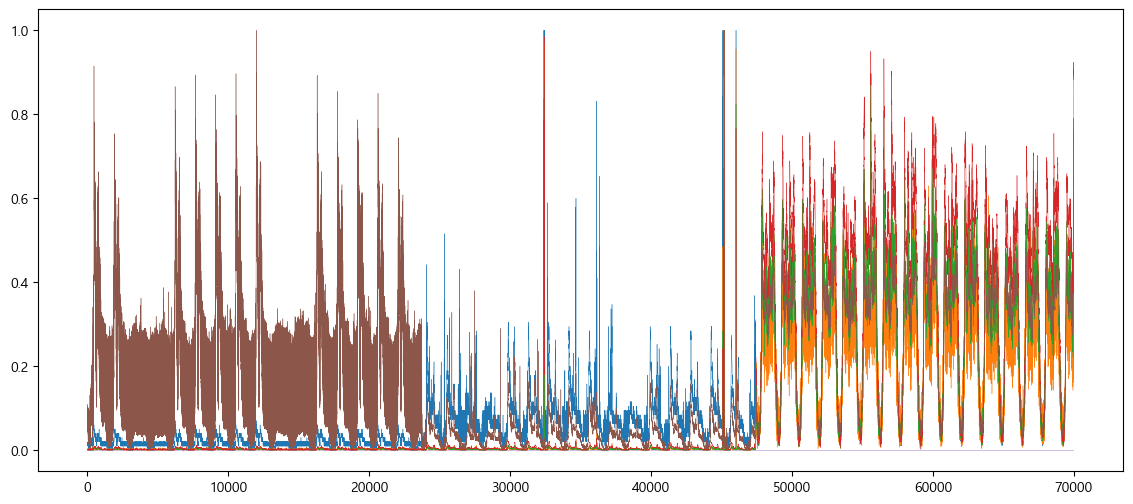

In [92]:
data = np.load('dataset/SMD' + "/SMD_train.npy")
print(data.shape)

plt.figure(figsize=(14,6))
#plt.ylim(0,3)
plt.plot(data[:70000,[0,1,2,3,4,30]],linewidth=0.3)
plt.show()

In [5]:
input_data, labels = next(iter(train_loader))
input_data.shape, labels.shape  # label은 해당 point가 anomaly인지 아닌지 표현

(torch.Size([256, 100, 55]), torch.Size([256, 100]))

In [46]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AnomalyTransformer(win_size=config.win_size, enc_in=config.input_c, c_out=config.output_c, e_layers=3).to(device)
model.train()

input = input_data.float().to(device)
output, series, prior, _ = model(input)

In [34]:
for ser, pri in zip(series, prior):
    print(ser.shape, pri.shape)
    
output.shape

torch.Size([256, 8, 100, 100]) torch.Size([256, 8, 100, 100])
torch.Size([256, 8, 100, 100]) torch.Size([256, 8, 100, 100])
torch.Size([256, 8, 100, 100]) torch.Size([256, 8, 100, 100])


torch.Size([256, 100, 55])

In [47]:
def my_kl_loss(p, q):
    res = p * (torch.log(p + 0.0001) - torch.log(q + 0.0001))
    return torch.mean(torch.sum(res, dim=-1), dim=1)


criterion = nn.MSELoss()

# calculate Association discrepancy
series_loss = 0.0
prior_loss = 0.0
for u in range(len(prior)):
    prior_v =  prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,config.win_size)
    prior_detach = prior_v.detach()
    series_loss += (torch.mean(my_kl_loss(series[u], prior_detach)) 
                  + torch.mean(my_kl_loss(prior_detach, series[u]))
                   )
    prior_loss += (torch.mean(my_kl_loss(prior_v, series[u].detach())) 
                 + torch.mean(my_kl_loss(series[u].detach(), prior_v))
                  )

series_loss = series_loss / len(prior)
prior_loss = prior_loss / len(prior)

rec_loss = criterion(output, input)

#loss1_list.append((rec_loss - config.k * series_loss).item())
loss1 = rec_loss - config.k * series_loss
loss2 = rec_loss + config.k * prior_loss

print(rec_loss.item(), loss1.item(), loss2.item())

0.9837008714675903 -23.17308807373047 25.140491485595703


### Models

In [ ]:
# (0)->(1)->(2)->(3)->(4) 순서로 호출되고, (4)->(3)->(2)->(1)->(0)순으로 실행
# 입력을 임베딩해서(0), 넘기면 att layer를 호출(1)하고, att레이어에서 self att을 호출(2)하고,
# self att에서 임베딩입력을 projection후 att계산부 호출(3), 그러면 (4)에서 prior, series att계산
# (0) 임베딩
# (1) 레이어별 호출
# (2) self att 호출
# (3) projection + att 계산 호출
# (4) att 계산

In [45]:
# from model.attn import AnomalyAttention, AttentionLayer
from model.embed import DataEmbedding, TokenEmbedding


class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    ########################################################### 
    # (2) self attention을 호출. x가 x,x,x로 넘어감
    ########################################################### 
    def forward(self, x, attn_mask=None):
        new_x, attn, mask, sigma = self.attention(
            x, x, x,
            attn_mask=attn_mask
        )
        
        x = x + self.dropout(new_x)
        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1, 1))))
        y = self.dropout(self.conv2(y).transpose(-1, 1))

        return self.norm2(x + y), attn, mask, sigma


class Encoder(nn.Module):
    def __init__(self, attn_layers, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.norm = norm_layer

    ########################################################### 
    # (1) 레이어별 호출: x받아 넘기는것 밖에 없음
    ########################################################### 
    def forward(self, x, attn_mask=None):
        # x [B, L, D]
        series_list = []
        prior_list = []
        sigma_list = []
        for attn_layer in self.attn_layers:
            x, series, prior, sigma = attn_layer(x, attn_mask=attn_mask)
            series_list.append(series)
            prior_list.append(prior)
            sigma_list.append(sigma)

        if self.norm is not None:
            x = self.norm(x)

        return x, series_list, prior_list, sigma_list


class AnomalyTransformer(nn.Module):
    def __init__(self, win_size, enc_in, c_out, d_model=512, n_heads=8, e_layers=3, d_ff=512,
                 dropout=0.0, activation='gelu', output_attention=True):
        super(AnomalyTransformer, self).__init__()
        self.output_attention = output_attention

        # Encoding
        self.embedding = DataEmbedding(enc_in, d_model, dropout)

        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        AnomalyAttention(win_size, False, attention_dropout=dropout, output_attention=output_attention),
                        d_model, n_heads
                    ),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation
                ) for l in range(e_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )

        self.projection = nn.Linear(d_model, c_out, bias=True)

    ########################################################### 
    # (0) 임베딩 + 엔코더 호출
    ########################################################### 
    def forward(self, x):
        enc_out = self.embedding(x)
        #pdb.set_trace()
        enc_out, series, prior, sigmas = self.encoder(enc_out)
        enc_out = self.projection(enc_out)

        if self.output_attention:
            return enc_out, series, prior, sigmas
        else:
            return enc_out  # [B, L, D]

In [37]:
from math import sqrt


class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask


class AnomalyAttention(nn.Module):
    def __init__(self, win_size, mask_flag=True, scale=None, attention_dropout=0.0, output_attention=False):
        super(AnomalyAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)
        window_size = win_size
        self.distances = torch.zeros((window_size, window_size)).cuda()
        
        for i in range(window_size):
            for j in range(window_size):
                self.distances[i][j] = abs(i - j)

    ########################################################### 
    # (4) 실제 attention 계산. prior, series distribution계산
    ########################################################### 
    def forward(self, queries, keys, values, sigma, attn_mask):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1. / sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)
        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)
            scores.masked_fill_(attn_mask.mask, -np.inf)
        attn = scale * scores

        sigma = sigma.transpose(1, 2)  # B L H ->  B H L
        window_size = attn.shape[-1]
        sigma = torch.sigmoid(sigma * 5) + 1e-5
        sigma = torch.pow(3, sigma) - 1
        sigma = sigma.unsqueeze(-1).repeat(1, 1, 1, window_size)  # B H L L
        prior = self.distances.unsqueeze(0).unsqueeze(0).repeat(sigma.shape[0], sigma.shape[1], 1, 1).cuda()
        prior = 1.0 / (math.sqrt(2 * math.pi) * sigma) * torch.exp(-prior ** 2 / 2 / (sigma ** 2))

        series = self.dropout(torch.softmax(attn, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", series, values)

        if self.output_attention:
            return (V.contiguous(), series, prior, sigma)
        else:
            return (V.contiguous(), None)


class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, d_keys=None,
                 d_values=None):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)
        d_values = d_values or (d_model // n_heads)
        self.norm = nn.LayerNorm(d_model)
        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model,
                                          d_keys * n_heads)
        self.key_projection = nn.Linear(d_model,
                                        d_keys * n_heads)
        self.value_projection = nn.Linear(d_model,
                                          d_values * n_heads)
        self.sigma_projection = nn.Linear(d_model,
                                          n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)

        self.n_heads = n_heads

    ########################################################### 
    # (3) Projection + 실제 att 계산부 호출
    ########################################################### 
    def forward(self, queries, keys, values, attn_mask):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads
        x = queries
        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)
        sigma = self.sigma_projection(x).view(B, L, H)

        out, series, prior, sigma = self.inner_attention(
            queries,
            keys,
            values,
            sigma,
            attn_mask
        )
        out = out.view(B, L, -1)

        return self.out_projection(out), series, prior, sigma